# Семинар 3 - Алгоритмы предварительной обработки изображений и их реализация

***

In [1]:
from pathlib import Path
import random

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Свертка (Convolution)

1. Определение

![](https://upload.wikimedia.org/wikipedia/commons/6/6e/Convolution_of_box_signal_with_itself.gif "conv1")

![](https://upload.wikimedia.org/wikipedia/commons/6/67/Convolution_of_spiky_function_with_box.gif "conv2")

$\textbf{Свёртка, конволюция}$ — операция, которая при применении к двум функциям 
$f(x)$ и $g(x)$ возвращает третью функцию, соответствующую взаимнокорреляционной функции $f(x)$ и $g(-x)$. Смысл - "схожесть" одного сигнала с отраженным другим. Другими словами, имеется система, подается на вход сигнал, выход системы - результат свертки.

В компьютерном зрении часто рассматривают как системы - различные фильтры (выделения краев, медианный фильтр и другие). Адаптивно подстраивая их, мы сможем получать нужные выходные сигналы.

Свойства:

1. $f*g = g*f$
2. $f*(g*h) = (f*g)*f*h$
3. $(f_{1}+f_{2})*g = f_{1}*g + f_{2}*g$
4. $(\alpha f)*g = f*(\alpha g)$

Одномерный случай свертки

$$ w(t) = \sum\limits_{\tau=0}^{t} g(\tau)^{*} f(t - \tau) $$

где ${*}$ означает комплексное сопряжение.

2. Теория

Идея свертки основывается на дискретном [преобразовании Фурье](https://ru.wikipedia.org/wiki/Преобразование_Фурье) (ДПФ). Можно разложить сигнал на элементарные составляющие - гармонические колебания с разными частотами. В получившийся частотной области исследовать сигнал проще.

Например, если рассматривать линейные системы, то если мы знаем характеристику системы $F$, то можем при любом входном сигнале $G$ получить выходной сигнал $W$ по формуле в частотной области: $W(w) = G(w)F(w)$

ДПФ прямое: $G(w) = \sum\limits_{t=0}^{N-1} g(t) e^{-\frac{2 \pi i}{N} w t}$.

ДПФ обратное: $g(t) = \frac{1}{N} \sum\limits_{w=0}^{N-1} G_(w) e^{\frac{2\pi i}{N} w t}$.

3. Визуализация в частотной области

Используя формулу Эйлера $e^{j\omega T} = cos(\omega T) + j\cdot sin(\omega T)$, можно определить *вещественную* и *мнимую* составляющие, а также **модуль** и **аргумент** спектральной плотности, которые связаны с вещественной и мнимой частями спектра через формулы теории функции комплексного переменного.

Модуль: $|X(kT)| = \sqrt{Re(X)^2 + Im(X)^2}$

Фаза: $arg(X(kT)) = \arctan{\frac{Im(X)}{Re(X)}}$







### Методы фильтрации изображений

Рассмотрим несколько стандартных моделей шума
1. $\textbf{Соль и перец}$ - случайные черные и белые пиксели
2. $\textbf{Импульсный}$ - случайные белые пиксели
3. $\textbf{Гауссов}$ - колебания яркости, распределенные по нормальному закону

Проанализируем часть из них на одномерных массивах

interactive(children=(IntSlider(value=1, description='value', max=30, min=-10), IntSlider(value=127, descripti…

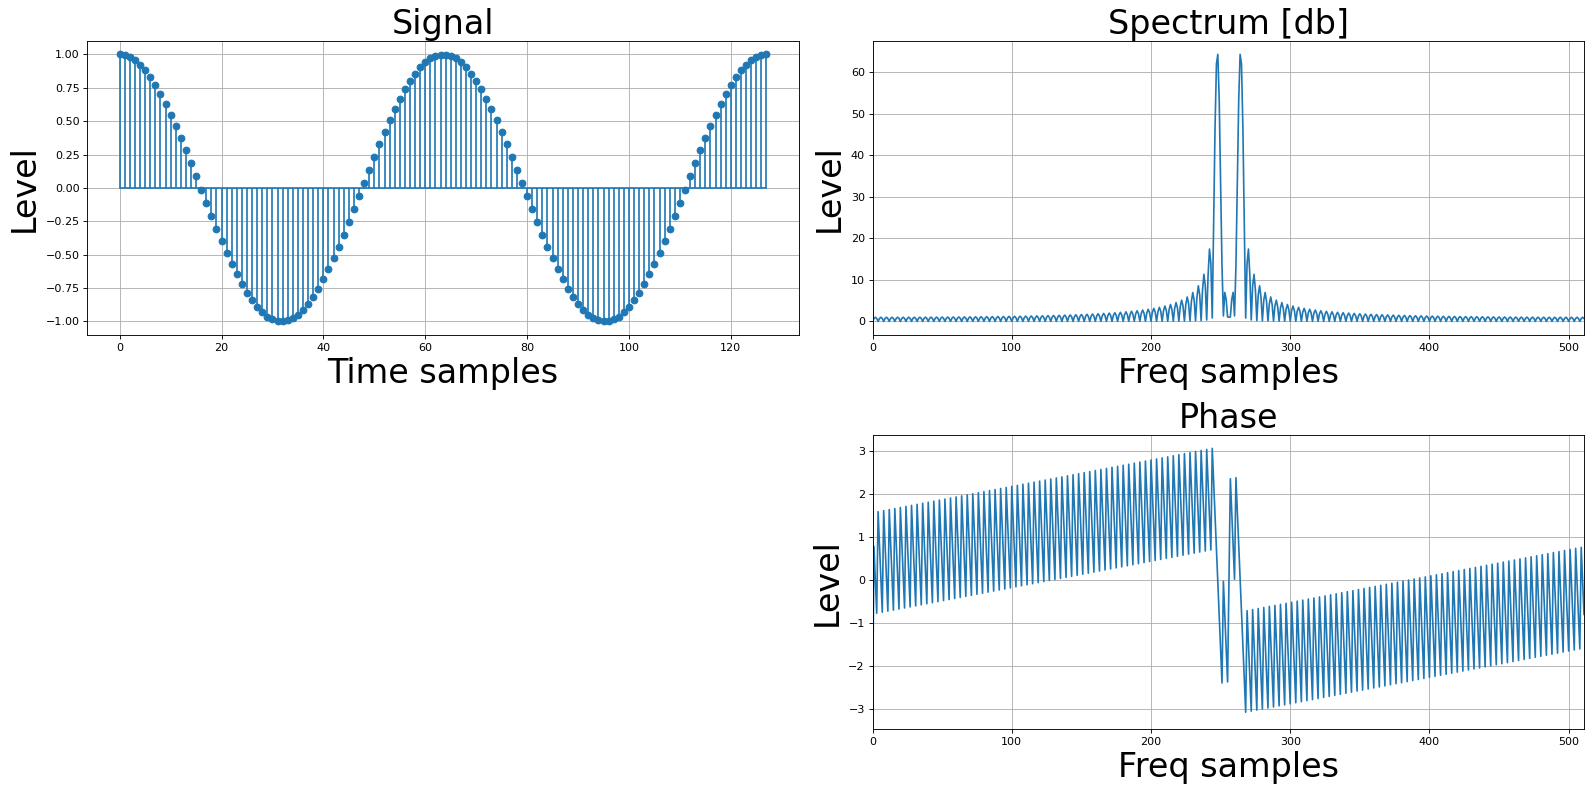

In [2]:
import ipywidgets
from scipy.fftpack import (
    fft, ifft,
    fft2, ifft2,
    fftshift, ifftshift,
)

def viz_signal(
    signal: list,
) -> None:

    # signal
    x = np.array(signal)

    # Forward FFT
    N = 512
    xFFT = fftshift(fft(x, N))
    # Magnitude spectrum
    xA = np.abs(xFFT)
    # Phase spectrum
    xF = np.angle(xFFT)

    # List of signals
    xT = [x, xA, xF, ]
    lst_title = ['Signal', 'Spectrum [db]', 'Phase']

    # Plot results
    fig = plt.figure(figsize=(20, 10), dpi=80)

    for i, sig in enumerate(xT):
        plt.subplot(2, 2, int(2**i))
        plt.ylabel('Level', fontsize=30)
        plt.title(lst_title[i], fontsize=30)
        if i == 0:
            plt.stem(sig, basefmt='C0')
            plt.xlabel('Time samples', fontsize=30)
        else:
            plt.plot(sig)
            plt.xlabel('Freq samples', fontsize=30)
            plt.xlim([0, N - 1])
        plt.grid()

    plt.tight_layout()

#define signal
N = 128
# time vector
t = np.linspace(0, 1, N)
# freq
f1 = 2
signal = np.cos(2*np.pi*f1*t)

@ipywidgets.interact(
    value=ipywidgets.IntSlider(
        min=-10, max=30,
        step=1, value=signal[N - 1],
    ),
    pos=ipywidgets.IntSlider(
        min=0, max=N,
        step=1, value=N - 1,
    ),
)
def play_with_signal(
    value: int,
    pos: int,
) -> None:

    signal[pos] = value

viz_signal(signal)

# Упражнение 1  (оцениваемое)

**Это и дальнейшие упражнения и вопросы будут оцениваться**

Реализуйте шумы типа соль/перец и гаусcов шум. Визуализируйте результаты - добавьте шум к предложенному изображению астронавта.

In [3]:
def saltpepper_noise(
    image: np.array,
    proportion: float=0.2,
) -> np.array:
    coords = {
        "salt": set(),
        "pepper": set(),
    }
    keys = ["salt", "pepper"]
    
    h, w = image.shape
    noisy_image = image.copy()

    while len(coords["salt"]) + len(coords["pepper"]) < proportion * h * w:
        x, y = random.randint(0, h - 1), random.randint(0, w - 1)
        key = random.choice(keys)
        coords[key].add((x, y))

    for x, y in coords["salt"]:
        noisy_image[x, y] *= 0
        noisy_image[x, y] += 255

    for x, y in coords["pepper"]:
        noisy_image[x, y] *= 0
        
    return noisy_image

def gaussian_noise(
    image: np.array,
    mean: float=0.04,
    sigma: float=0.07,
) -> np.array:
    mean, sigma = mean * 255, sigma * 255
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image

def do_nothing(
    image: np.array,
) -> np.array:
    return image

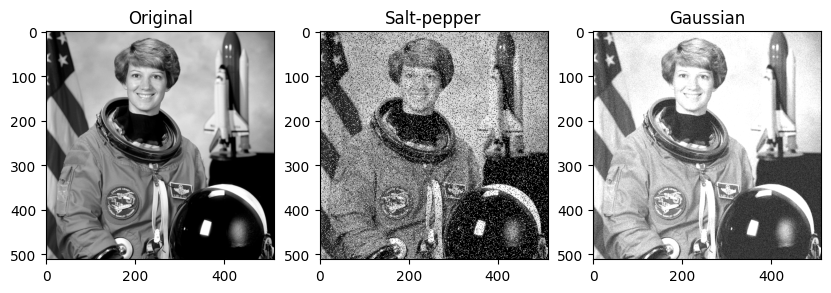

In [4]:
from skimage import data

astronaut_img = cv2.cvtColor(
    src=data.astronaut(),
    code=cv2.COLOR_RGB2GRAY,
)

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(do_nothing(astronaut_img), cmap="gray")
plt.title('Original')

plt.subplot(132)
plt.imshow(saltpepper_noise(astronaut_img), cmap="gray")
plt.title('Salt-pepper')

plt.subplot(133)
plt.imshow(gaussian_noise(astronaut_img, 0.25, 0.05), cmap="gray")
plt.title('Gaussian')

plt.show()

# Упражнение 2

Посмотрите также разницу на других фотографиях - они доступны в `skimage.data`

/Users/rito4ka/dev/base_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


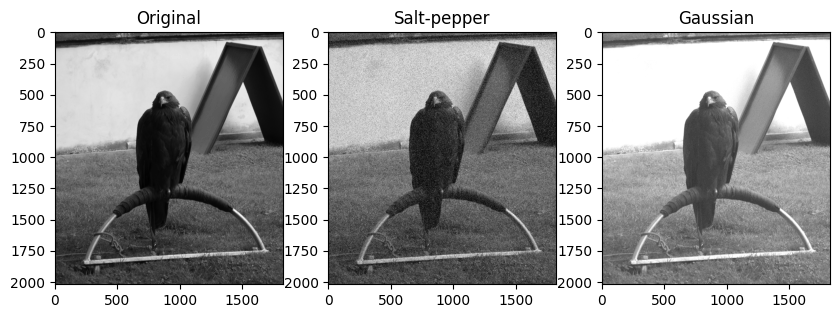

In [5]:
eagle_img = data.eagle()

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(do_nothing(eagle_img), cmap="gray")
plt.title('Original')

plt.subplot(132)
plt.imshow(saltpepper_noise(eagle_img), cmap="gray")
plt.title('Salt-pepper')

plt.subplot(133)
plt.imshow(gaussian_noise(eagle_img, 0.25, 0.05), cmap="gray")
plt.title('Gaussian')

plt.show()

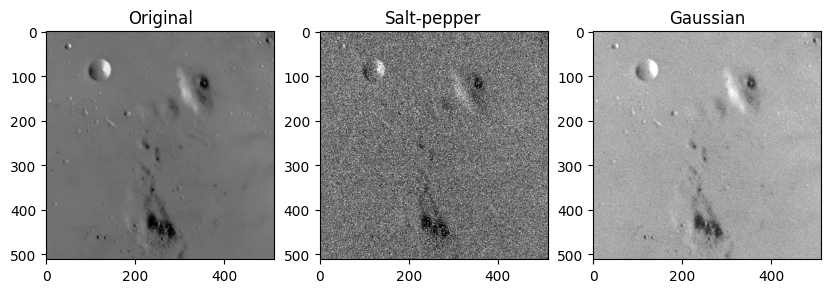

In [6]:
moon_img = data.moon()

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(do_nothing(moon_img), cmap="gray")
plt.title('Original')

plt.subplot(132)
plt.imshow(saltpepper_noise(moon_img), cmap="gray")
plt.title('Salt-pepper')

plt.subplot(133)
plt.imshow(gaussian_noise(moon_img, 0.25, 0.05), cmap="gray")
plt.title('Gaussian')

plt.show()

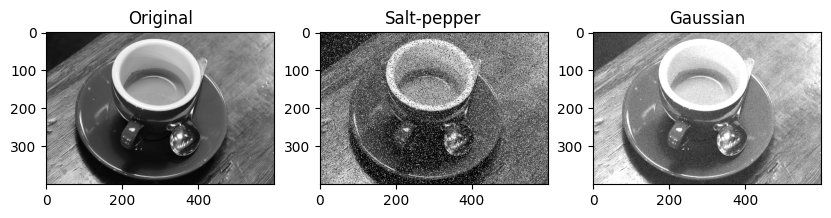

In [7]:
coffee_img = cv2.cvtColor(
    src=data.coffee(),
    code=cv2.COLOR_RGB2GRAY,
)

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(do_nothing(coffee_img), cmap="gray")
plt.title('Original')

plt.subplot(132)
plt.imshow(saltpepper_noise(coffee_img), cmap="gray")
plt.title('Salt-pepper')

plt.subplot(133)
plt.imshow(gaussian_noise(coffee_img, 0.25, 0.05), cmap="gray")
plt.title('Gaussian')

plt.show()

# Базовые фильтры

![](http://www.djvu-soft.narod.ru/bookscanlib/cf1.jpg)

![](http://www.djvu-soft.narod.ru/bookscanlib/cf2.jpg)

Рассмотрим линейные фильтры, основанные, конечно же, на конволюции.

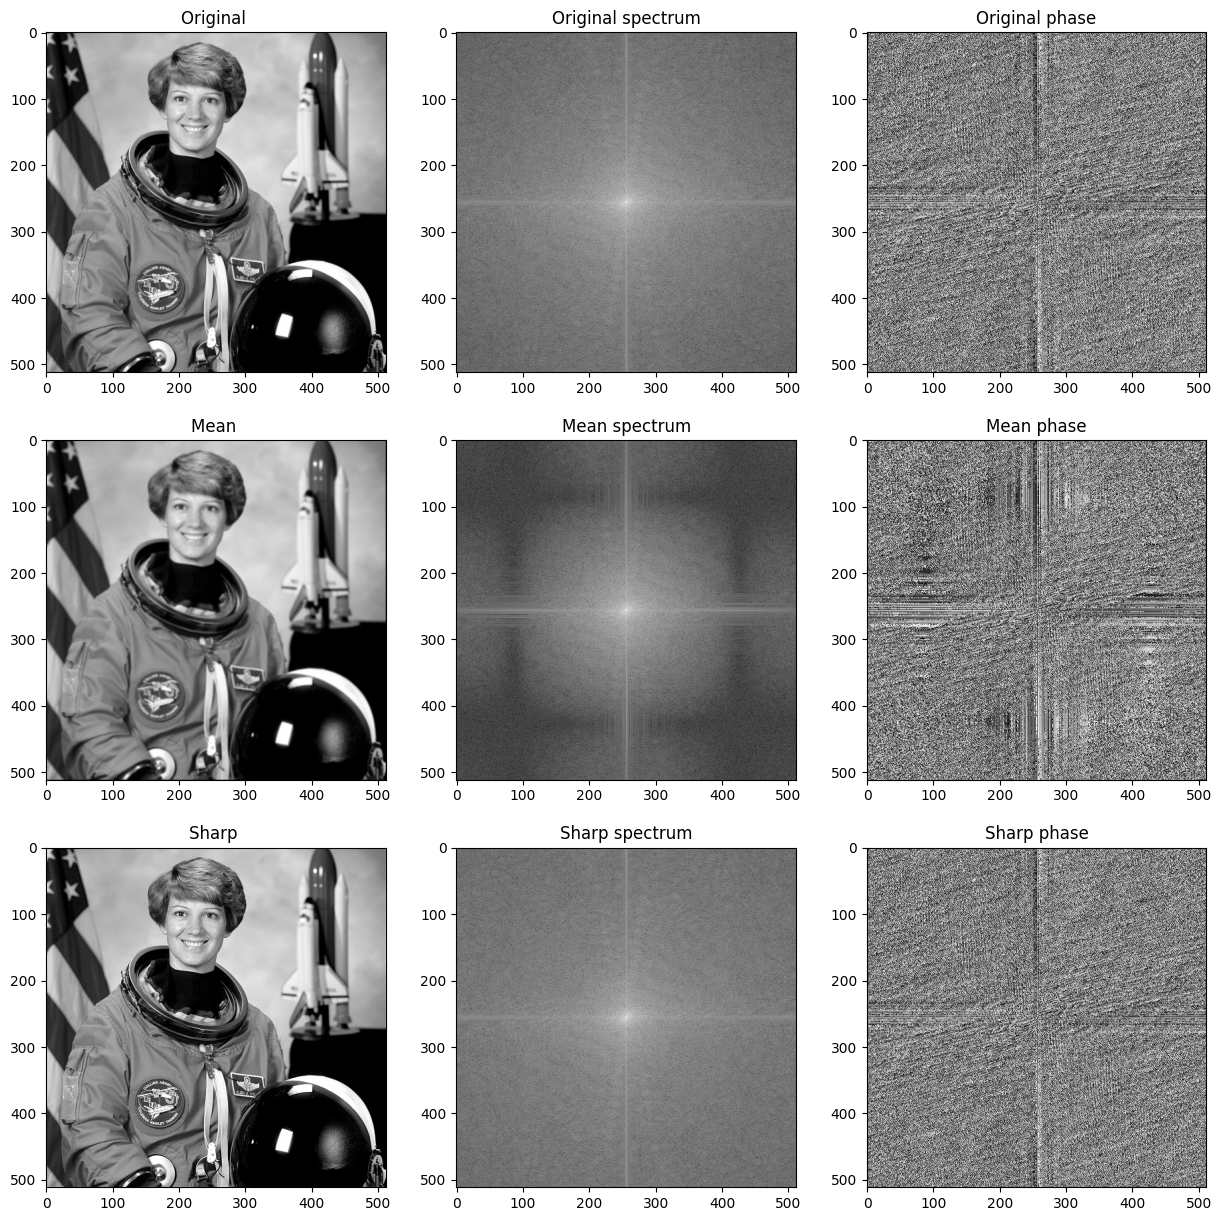

In [39]:
def get_spectrum_and_phase(image):
    shifted_spectrum = fftshift(fft2(image))
    magnitude_spectrum = np.abs(shifted_spectrum)
    phase = np.angle(shifted_spectrum)
    
    return magnitude_spectrum, phase

nothing = np.array([
    [1., ],
])

mean = np.array([
    [1, 1, 1, ],
    [1, 1, 1, ],
    [1, 1, 1, ],
]) / 9

sharp = np.array([
    [0, -1, 0, ],
    [-1, 9, -1, ],
    [0, -1, 0, ],
]) / 5

filters = [nothing, mean, sharp, ]
lst_title = ['Original', 'Mean', 'Sharp',]
pic_title = ['', 'spectrum', 'phase',]

# fig, axes = plt.subplots(
#     ncols=len(lst_title),
#     sharex=True,
#     sharey=True,
#     figsize=(15, 45),
#     dpi=80,
# )
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(filters)):
    filtered_img = cv2.filter2D(
        src=astronaut_img,
        kernel=filters[i],
        ddepth=-1, #the same depth as input
        borderType=cv2.BORDER_CONSTANT,
        anchor=(-1, -1), #center of the kernel
        delta=0, #additional data added to
    )

    spectrum, phase = get_spectrum_and_phase(filtered_img)
    spectrum = np.log(spectrum)

    for j, img in enumerate([filtered_img, spectrum, phase]):
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{lst_title[i]} {pic_title[j]}")

    # axes[i].imshow(filtered_img, cmap='gray')
    # axes[i].set_title(lst_title[i], fontsize=30)

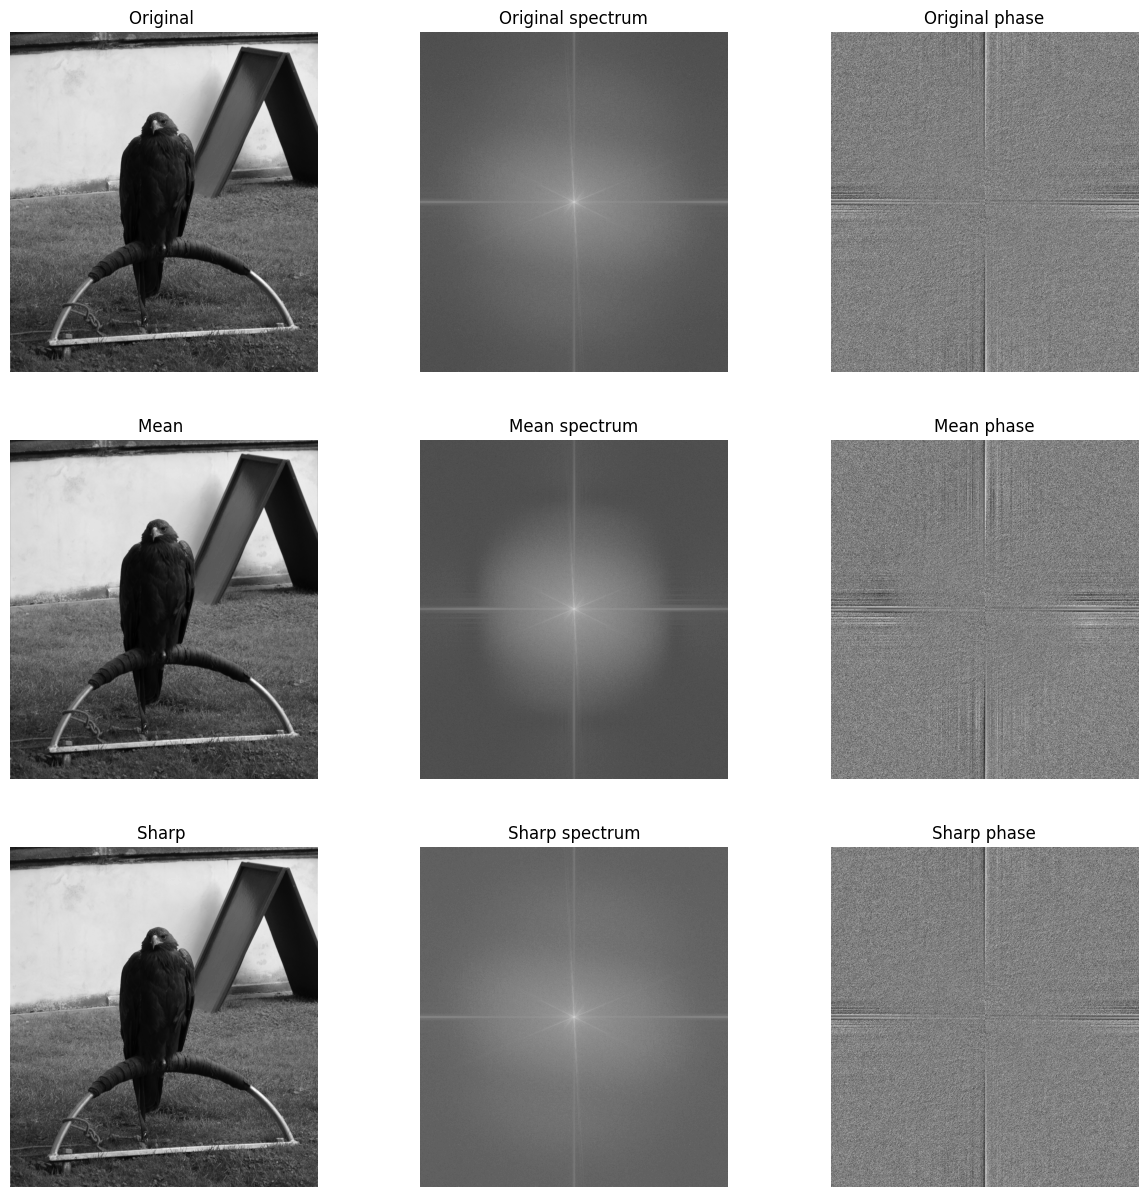

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(filters)):
    filtered_img = cv2.filter2D(
        src=eagle_img,
        kernel=filters[i],
        ddepth=-1, #the same depth as input
        borderType=cv2.BORDER_CONSTANT,
        anchor=(-1, -1), #center of the kernel
        delta=0, #additional data added to
    )

    spectrum, phase = get_spectrum_and_phase(filtered_img)
    spectrum = np.log(spectrum)

    for j, img in enumerate([filtered_img, spectrum, phase]):
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{lst_title[i]} {pic_title[j]}")

Особенность свертки - ее локальность. Чем больше ядро светки - тем в большей окрестности она охватывает пиксели.

# Вопрос

Проанализируйте спектр и фазы зашумленных сигналов после применения фильтров. Что изменилось?

**Ответ:** mean увеличивает дельту между разными интенсивностями более заметной, в то время как sharp, как будто, имеет обратный эффект; аналогично и для фазовой диаграммы.

# Упражение 3

Реализуйте свою свертку и сравните с реализацией `cv2.filter2D` (визуализируйте результаты работы своей свертки и библиотечной с одинаковым ядром + посмотрите на разность значений пикселей после обработки).

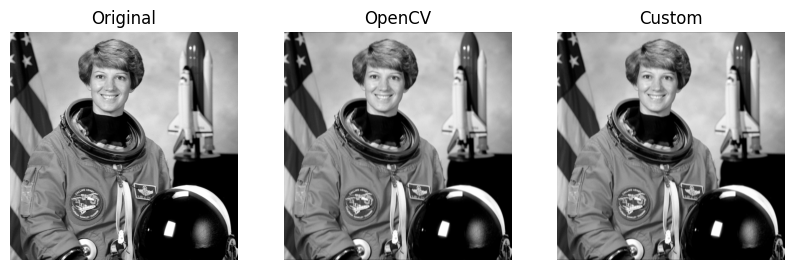

[[255   0 255 ... 255   0 255]
 [  0 255   0 ...   0 255   0]
 [255   0   0 ...   0 255 255]
 ...
 [  0 255   0 ...   0   0   0]
 [255   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]]


In [54]:
# Если тут оставить отрицательные значения, то появятся артефакты в кастомной свёртке :(
vertical_lines = np.array([
    [-2, 5, -2, ],
    [-2, 5, -2, ],
    [-2, 5, -2, ],
]) / 3

vertical_lines = np.array([
    [0, 5, 0, ],
    [0, 5, 0, ],
    [0, 5, 0, ],
]) / 15

def conv2d(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    convolved_image = np.zeros_like(image)
    kernel = np.flipud(np.fliplr(kernel))
    
    padded_image = np.pad(image, ((kernel_height // 2, kernel_height // 2), (kernel_width // 2, kernel_width // 2)))
    for i in range(image_height):
        for j in range(image_width):
            convolved_image[i, j] = np.sum(np.multiply(padded_image[i:i+kernel_height, j:j+kernel_width], kernel))
    return convolved_image

plt.figure(figsize=[10, 30])

plt.subplot(131)
plt.imshow(do_nothing(astronaut_img), cmap="gray")
plt.title('Original')
plt.axis('off')

plt.subplot(132)
cv2_astro = cv2.filter2D(
    src=astronaut_img,
    kernel=vertical_lines,
    ddepth=-1,
    borderType=cv2.BORDER_CONSTANT,
    anchor=(-1, -1),
    delta=0,
)
plt.imshow(cv2_astro, cmap="gray")
plt.title('OpenCV')
plt.axis('off')

custom_astro = conv2d(astronaut_img, vertical_lines)
plt.subplot(133)
plt.imshow(custom_astro, cmap="gray")
plt.title('Custom')
plt.axis('off')

plt.show()

print(np.abs(custom_astro - cv2_astro))

Рассмотрим нелинейные фильтры. Многие из них нелокальны и адаптивны.

1. Медианный фильтр
```python
filtered_img = cv2.medianBlur(
      src=img,
      ksize=(5, 5), #kernel size
)
```
2. Гистограмное выравнивание
```python
filtered_img = cv2.equalizeHist(
      src=img,
)
```
3. Contrast Limited Adaptive Histogram Equalization (CLAHE). Описание [англ](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE)
```python
clahe = cv2.createCLAHE(
      clipLimit=40.0, # Threshold for contrast limiting
      tileGridSize=(8, 8),  # Grid size
)
filtered_img = clahe.apply(img)
```
4. Билатеральный фильтр. Описание [англ](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html), [рус](https://habr.com/ru/post/273159/)
```python
filtered_img = cv2.bilateralFilter(
      src=img,
      d=9, #Diameter of each pixel neighborhood
      sigmaColor=75,  #Filter sigma in the color space
      sigmaSpace=75, #Filter sigma in the coordinate space
      borderType=cv2.BORDER_CONSTANT,
)
```

Разберем подробнее 

# Гистограмное Выравнивание

Рассмотрим изображение, значения пикселей которого ограничены только определенным диапазоном значений. Например, на более ярком изображении все пиксели будут ограничены высокими значениями. Но хорошее изображение будет содержать пиксели из всех областей изображения. Поэтому вам нужно растянуть эту гистограмму до обоих концов, и это то, что делает выравнивание гистограммы (простыми словами). Обычно это улучшает контрастность изображения.

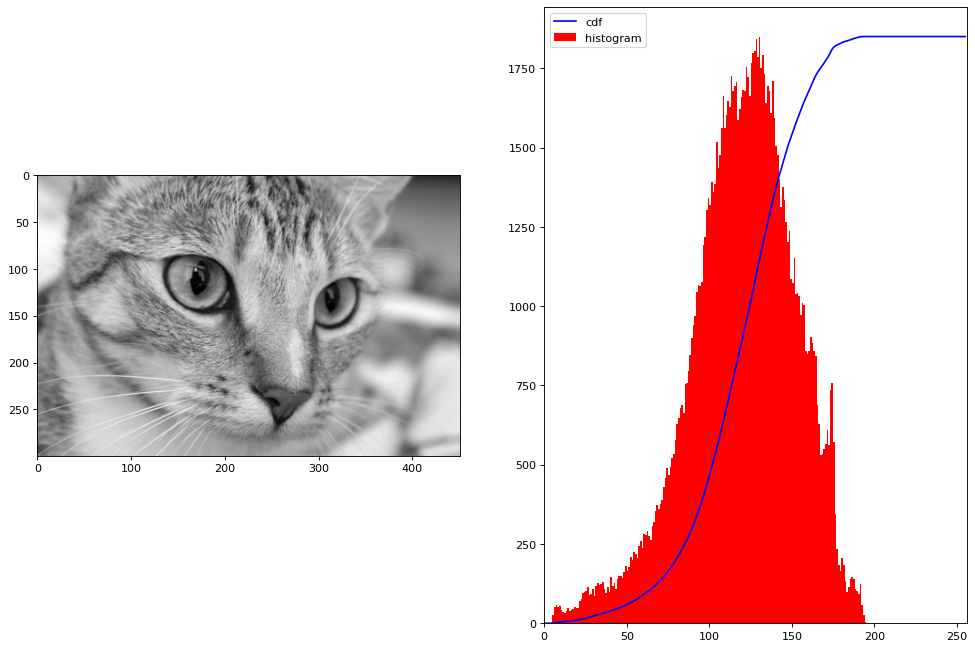

In [11]:
cat_img = cv2.cvtColor(
    src=data.cat(),
    code=cv2.COLOR_RGB2GRAY,
)

def plot_hist(
    img: np.array,
) -> None:

    fig, axes = plt.subplots(
        ncols=2,
        figsize=(15, 10),
        dpi=80,
    )

    axes[0].imshow(
        img,
        cmap='gray',
    )

    hist, bins = np.histogram(
        a=img.flatten(),
        bins=256,
        range=[0,256],
    )
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    axes[1].plot(
        cdf_normalized,
        color='b',
    )
    axes[1].hist(
        x=img.flatten(),
        bins=256,
        range=[0,256],
        color='r',
    )
    axes[1].set_xlim([0,256])
    axes[1].legend(
        ('cdf','histogram'),
        loc='upper left',
    )

def plot_unhist(
    img: np.array,
) -> None:

    hist, bins = np.histogram(
        a=img.flatten(),
        bins=256,
        range=[0,256],
    )
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(
        x=cdf,
        value=0,
    )
    cdf_m = (cdf_m - cdf_m.min())/(cdf_m.max() - cdf_m.min()) * 255

    cdf = np.ma.filled(
        a=cdf_m,
        fill_value=0,
    )

    cdf = cdf.astype(np.uint8)

    img2 = cdf[img]

    plot_hist(img2)

plot_hist(cat_img)

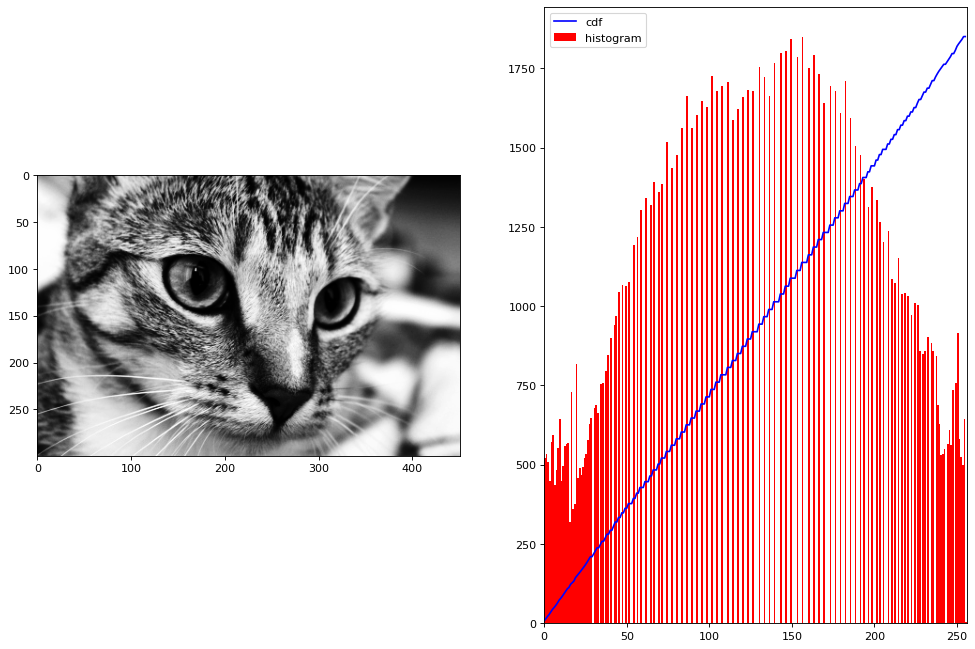

In [12]:
plot_unhist(cat_img)

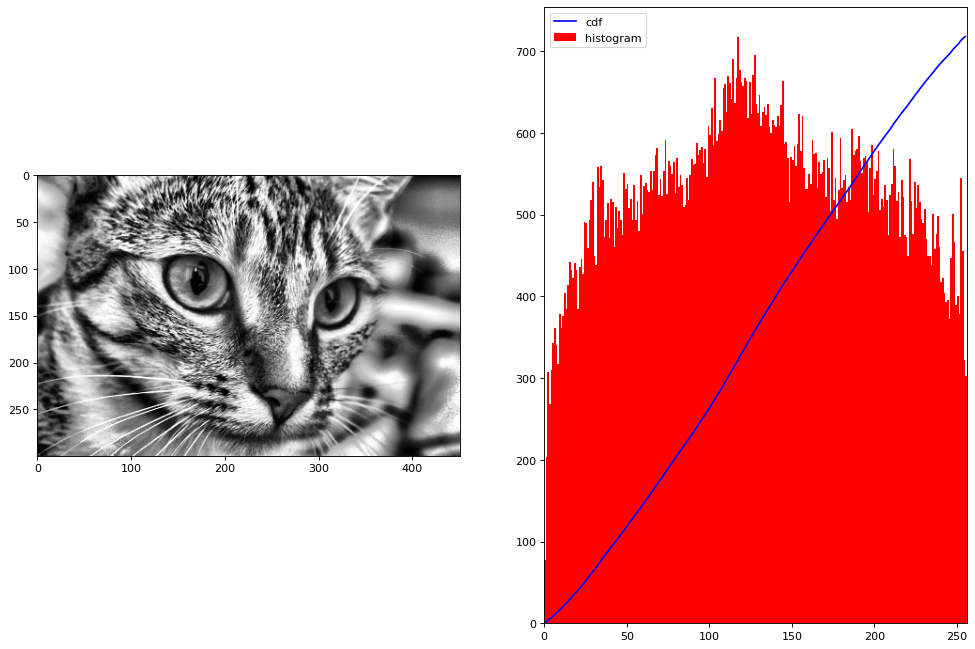

In [13]:
clahe = cv2.createCLAHE(
      clipLimit=40.0, # Threshold for contrast limiting
      tileGridSize=(8, 8),  # Grid size
)

filtered_cat_img = clahe.apply(cat_img)
plot_hist(filtered_cat_img)

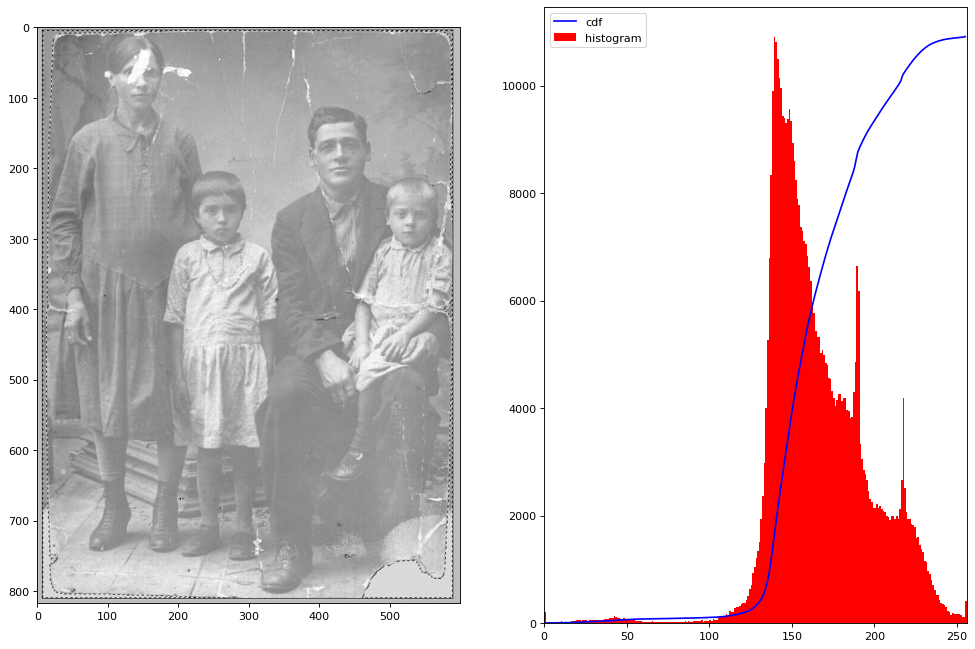

In [14]:
IMG_PATH = "data/image.jpg"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_03/data .

family_img = cv2.cvtColor(
    src=cv2.imread(IMG_PATH),
    code=cv2.COLOR_RGB2GRAY,
)

plot_hist(family_img)

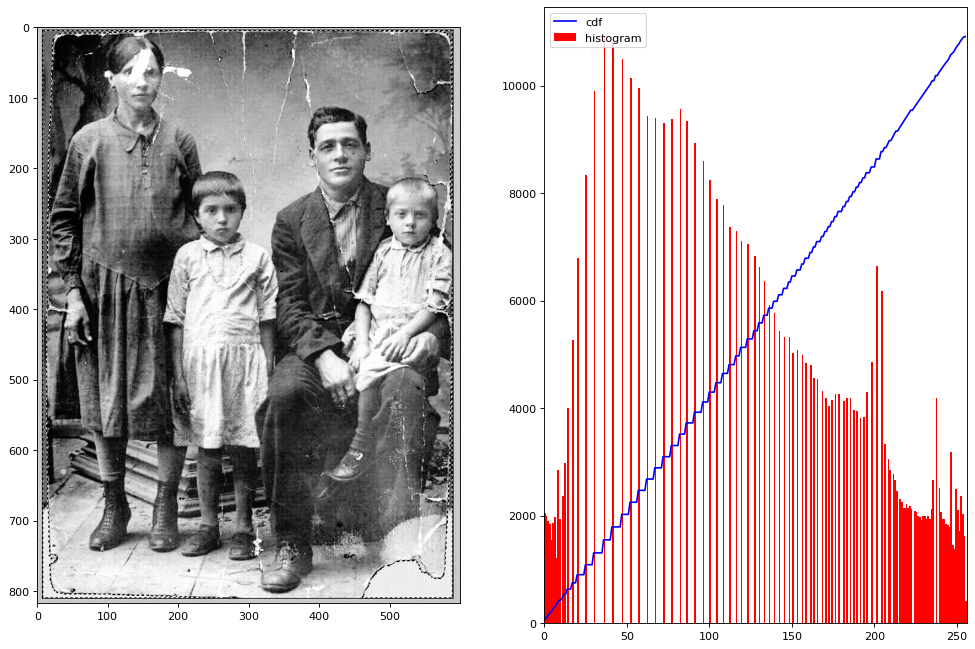

In [15]:
plot_unhist(family_img)

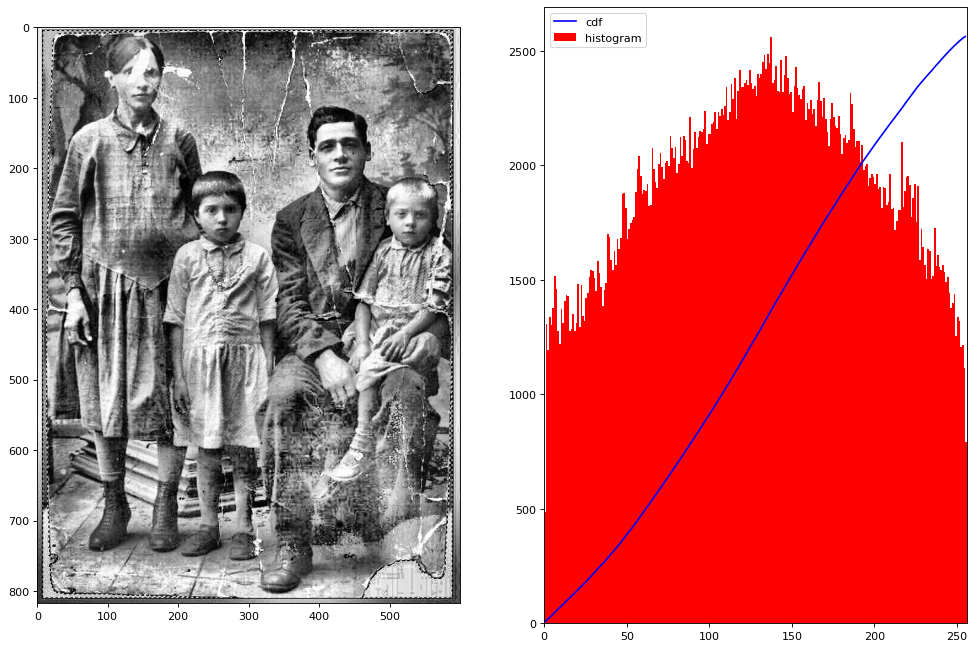

In [16]:
filtered_family_img = clahe.apply(family_img)

plot_hist(filtered_family_img)

# Упражнение 4

Примените адаптивное гистограммное выравнивание CLAHE (используйте `cv2`), сравните результат с тем, что получалось при обычном гистограммном выравнивании.

**Ответ:** см. примеры выше; выравнивание CLAHE приводит гистограмму изображения к более нормальному (нормальное распределение) виду. Это делает изображение более контрастным, при этом визуально сохраняя соотношение контрастности между регионами изображения (но по гистограмме как будто ничего оно не сохраняет).